In [1]:
import torch, random, os, time, pywt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchio as tio
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\PC00\anaconda3\envs\MR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

seed_everything(42)

In [3]:
tio_transform = [tio.ToCanonical(),
                 tio.transforms.RescaleIntensity(),
                 tio.Resample((1,1,1))]

ixi_dataset = tio.datasets.IXI("D:/Datasets/IXI/path/to/ixi_root",
                               modalities=('T2', 'PD'),
                               transform=tio.Compose(tio_transform),
                               download=False)

In [4]:
total_indexes = list(range(len(ixi_dataset)))
indexes_to_use = random.sample(total_indexes, 250)

# Hyperparameters (START)

In [ ]:
CFG={"IM_SIZE": 256,
     "TEs": list(range(10, 161, 10)),  # milli-sec
     "UNDERSAMPLE_RATE": 3,
     "Center_Fraction": 0.05,
     "Lambda_TV": 0.01,
     "Lambda_WVLT": 0.01,
     "LR": 0.0002,
     "Scheduler_gamma": 0.95,
     "EPOCHS": 200}

In [ ]:
model_root = "E:/model_save_path/Parameter_mapping/RELAX/"
os.makedirs(model_root, exist_ok=True)

""" !!CHANGE!! """
prev_try_num = 4 # Previous Step
model_prev_path = f"{model_root}{prev_try_num}.pt"

# "True" if additional training is needed
additive_train = False

""" !!CHANGE!! """
curr_try_num = 5 # Current Step
model_curr_path = f"{model_root}{curr_try_num}.pt"

In [7]:
test_compare = True

# Hyperparmeter Settings (END)

In [ ]:
class IXI_Dataset(Dataset):
    def __init__(self, total_data, indexes_to_use, resize=True):
        self.total_data = total_data
        self.indexes = indexes_to_use
        self.resize = resize
        self.im_size = CFG["IM_SIZE"]
        self.center_fraction = CFG["Center_Fraction"]
        self.under_rate = CFG["UNDERSAMPLE_RATE"]
        self.TEs = CFG["TEs"]
    
    def __len__(self):
        return len(self.indexes)
    
    def __get_multiechoes__(self, I0, T2):
        T2_safe = torch.clamp(T2, min=1e-9, max=2.0)
        mutliecho_images = [I0 * torch.exp(-1e-3*t/T2_safe) for t in self.TEs]
        return torch.stack(mutliecho_images, dim=0)
    
    def __1D_variable_density_mask__(self):
        W = self.im_size
        center_size = int(W * self.center_fraction)
        center_start = (W - center_size) // 2
        center_end = center_start + center_size

        total_masks = np.empty((len(self.TEs), W, W))
        x = np.arange(0, W)

        for echo in range(len(self.TEs)):
            echo_mask = np.zeros((W, W))
            echo_mask[:, center_start:center_end] = 1

            sampled_columns = set()
            while len(sampled_columns) < (W // self.under_rate - center_size):
                curr_sample = np.random.normal(np.mean(x), np.std(x), 1).astype(int).item()
                if curr_sample < 0 or curr_sample >= W: continue
                if center_start <= curr_sample < center_end: continue
                sampled_columns.add(curr_sample)

            for col in sampled_columns:
                echo_mask[:, col] = 1
            
            total_masks[echo] = echo_mask
        
        return torch.from_numpy(total_masks)
        
    def __undersampling__(self, multiecho_images, masks):
        multiecho_full_kspaces = torch.fft.fftshift(torch.fft.fft2(multiecho_images.to(torch.complex64), norm="ortho"))
        full_masked_reals = multiecho_full_kspaces.real * masks
        full_masked_imags = multiecho_full_kspaces.imag * masks
        multiecho_under_kspaces = torch.view_as_complex(torch.stack((full_masked_reals, full_masked_imags), dim=-1))
        multiecho_under_images = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(multiecho_under_kspaces), norm="ortho"))
        return multiecho_under_kspaces, multiecho_under_images
    
    def __getitem__(self, index):
        idx = self.indexes[index]
        subject = self.total_data[idx]
        ref_I0 = subject['PD'].data[0][:, :, 80]
        ref_T2 = subject['T2'].data[0][:, :, 80]
        if self.resize:
            ref_I0 = nn.functional.interpolate(ref_I0.unsqueeze(0).unsqueeze(0), size=(CFG["IM_SIZE"], CFG["IM_SIZE"]), mode="bilinear", align_corners=False).squeeze() # (256, 256)
            ref_T2 = nn.functional.interpolate(ref_T2.unsqueeze(0).unsqueeze(0), size=(CFG["IM_SIZE"], CFG["IM_SIZE"]), mode="bilinear", align_corners=False).squeeze() # (256, 256)
        multiecho_images = self.__get_multiechoes__(ref_I0, ref_T2)  # (8, 256, 256)
        echo_masks = self.__1D_variable_density_mask__()
        ref_kspace, i_u = self.__undersampling__(multiecho_images, echo_masks)
        return i_u.to(torch.float32), ref_I0.to(torch.float32), ref_T2.to(torch.float32), ref_kspace, echo_masks.to(torch.float32) # GPU 연산에 float64(double)이나 int형은 비효율적

In [9]:
total_dataset = IXI_Dataset(ixi_dataset, indexes_to_use, resize=True)
train_dataset, test_dataset = random_split(total_dataset, [200, 50])
train_loader, test_loader = DataLoader(train_dataset, 1), DataLoader(test_dataset, 1)
print(len(train_dataset), len(test_dataset))

200 50


torch.Size([1, 16, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 16, 256, 256])


(<Axes: >, <matplotlib.image.AxesImage at 0x23faf946f90>)

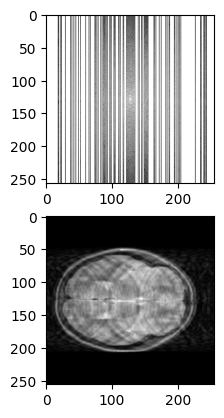

In [10]:
iu, I0, T2, dj, masks = next(iter(train_loader))
print(iu.shape, I0.shape, T2.shape, dj.shape)
plt.subplot(211), plt.imshow(torch.log(torch.abs(dj[0][0])), cmap="gray")
plt.subplot(212), plt.imshow(iu[0][0], cmap='gray')

(<Axes: >, <matplotlib.image.AxesImage at 0x23faf968b90>)

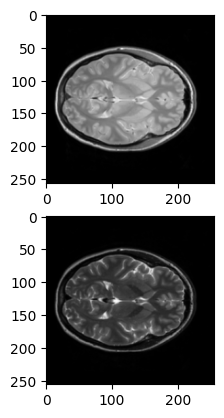

In [11]:
plt.subplot(211), plt.imshow(I0[0], cmap='gray')
plt.subplot(212), plt.imshow(T2[0], cmap='gray')

In [12]:
class shiftedReLU(nn.Module):
    def __init__(self, eps=1e-9):
        super(shiftedReLU, self).__init__()
        self.eps = eps
    
    def forward(self, x):
        return F.relu(x) + self.eps

In [13]:
class brown_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(brown_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=True)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.bn(self.conv(x))
    
class contracting_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(contracting_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=True)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sh_relu = shiftedReLU(eps=1e-6)

    def forward(self, x):
        return self.sh_relu(self.bn(self.conv(x)))

class expanding_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(expanding_block, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=True)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sh_relu = shiftedReLU(eps=1e-6)

    def forward(self, x):
        return self.sh_relu(self.bn(self.deconv(x)))

class blue_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(blue_block, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=True)
        self.sh_relu = shiftedReLU(eps=1e-6)

    def forward(self, x):
        return self.sh_relu(self.deconv(x))
    
class cyan_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(cyan_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True) # Different with seed paper -> WHY? (kernel, stride, padding)
        self.sh_relu = shiftedReLU(eps=1e-6)
    
    def forward(self, x):
        return self.sh_relu(self.conv(x))

In [14]:
class Res_UNet(nn.Module):
    def __init__(self):
        super(Res_UNet, self).__init__()
        self.fusion = brown_block(16, 64)

        self.encoder1 = contracting_block(64, 128)
        self.encoder2 = contracting_block(128, 256)
        self.encoder3 = contracting_block(256, 512)
        self.encoder4 = contracting_block(512, 512)
        self.encoder5 = nn.Sequential(contracting_block(512, 512), contracting_block(512, 512)) # block 3개 하면 (1,512,1,1) -> train error (모든 채널 차원이 1이상이어야 함?)

        self.decoder1 = nn.Sequential(expanding_block(512, 512), expanding_block(512, 512))
        self.decoder2 = expanding_block(1024, 512)
        self.decoder3 = expanding_block(1024, 256)
        self.decoder4 = expanding_block(512, 128)
        self.decoder5 = expanding_block(256, 64)

        self.non_residual = blue_block(128, 2)
        self.estimation = cyan_block(18, 2)

        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x_fused = self.fusion(x)

        # Encoder path
        x_en1 = self.encoder1(x_fused)
        x_en2 = self.encoder2(x_en1)
        x_en3 = self.encoder3(x_en2)
        x_en4 = self.encoder4(x_en3)
        x_en5 = self.encoder5(x_en4)

        # Decoder path
        x_de1 = self.decoder1(x_en5)
        x_de2 = self.decoder2(torch.cat((x_de1, x_en4), dim=1))
        x_de3 = self.decoder3(torch.cat((x_de2, x_en3), dim=1))
        x_de4 = self.decoder4(torch.cat((x_de3, x_en2), dim=1))
        x_de5 = self.decoder5(torch.cat((x_de4, x_en1), dim=1))

        x_nonresidual = self.non_residual(torch.cat((x_de5, x_fused), dim=1))
        out = self.estimation(torch.cat((x_nonresidual, x), dim=1))

        return out
    
# Self-Supervised Learning
class SSL_Loss(nn.Module):
    def __init__(self, lambda_tv=0.01, lambda_wavelet=0.01):
        super(SSL_Loss, self).__init__()
        self.lambda_tv = lambda_tv
        self.lambda_wavelet = lambda_wavelet
        self.TEs = CFG["TEs"]
        self.mse_loss = nn.MSELoss()
    
    def __TV_regularization__(self, x):
        tv_h = torch.mean(torch.abs(x[:, 1:, :] - x[:, :-1, :]))
        tv_w = torch.mean(torch.abs(x[:, :, 1:] - x[:, :, :-1]))
        return tv_h + tv_w

    def __wavelet_sparsity__(self, x, wavelet="db1", level=2):
        loss = 0.0
        for b in range(x.shape[0]):
            x_np = x[b].detach().cpu().numpy()
            if x_np.ndim == 3:
                x_np = x_np[0]
            coeffs = pywt.wavedec2(x_np, wavelet=wavelet, level=level)
            for coeff_level in coeffs[1:]:
                for detail in coeff_level:
                    loss += torch.tensor(np.sum(np.abs(detail)), dtype=torch.float32)
        return loss / x.shape[0]

    def forward(self, pred_I0, pred_T2, gt_kspaces, masks):
        T2_safe = torch.clamp(pred_T2, min=1e-9, max=3.0)
        reconstructed_kspaces = [torch.fft.fftshift(torch.fft.fft2( (pred_I0 * torch.exp(-1e-3*t/T2_safe)).to(torch.complex64), norm="ortho" )) for t in self.TEs]
        real_tensor, imag_tensor = torch.zeros((16, CFG["IM_SIZE"], CFG["IM_SIZE"])) , torch.zeros((16, CFG["IM_SIZE"], CFG["IM_SIZE"]))
        for ch in range(len(reconstructed_kspaces)):
            real_tensor[ch] = reconstructed_kspaces[ch].real.to(torch.float32)
            imag_tensor[ch] = reconstructed_kspaces[ch].imag.to(torch.float32)
        real_masked, imag_masked = real_tensor.to(device) * masks, imag_tensor.to(device) * masks
        ref_real, ref_imag = gt_kspaces.real.to(torch.float32), gt_kspaces.imag.to(torch.float32)
        real_loss = sum([self.mse_loss(real_k, real_masked[idx]) for idx, real_k in enumerate(ref_real)])
        imag_loss = sum([self.mse_loss(imag_k, imag_masked[idx]) for idx, imag_k in enumerate(ref_imag)])

        tv_I0 = self.__TV_regularization__(pred_I0)
        tv_T2 = self.__TV_regularization__(pred_T2)
        tv_loss = tv_I0 + tv_T2

        wavelet_loss = self.__wavelet_sparsity__(pred_T2)

        return (real_loss + imag_loss) + self.lambda_tv * tv_loss + self.lambda_wavelet * wavelet_loss

In [15]:
model = Res_UNet()
model = nn.DataParallel(model)
model.to(device)
loss_fn = SSL_Loss(lambda_tv=CFG["Lambda_TV"], lambda_wavelet=CFG["Lambda_WVLT"]).to(device)
optim = torch.optim.Adam(model.parameters(), lr=CFG["LR"])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=CFG["Scheduler_gamma"])

In [16]:
if additive_train:
    model.load_state_dict(torch.load(model_prev_path))

In [17]:
# def safe_activation(x, min_val=1e-9, max_val=1.0):
#     return torch.clamp(nn.functional.softplus(x) + 0.5, min=min_val, max=max_val)

In [18]:
# TRAIN LOOP
torch.autograd.set_detect_anomaly(True)
model.train()
for epoch in range(200):
    start_time = time.time()
    for i_u, gt_I0, gt_T2, dj, masks in train_loader:
        i_u, gt_I0, gt_T2, dj, masks = i_u.to("cuda"), gt_I0.to("cuda"), gt_T2.to("cuda"), dj.to("cuda"), masks.to("cuda")
        output = model(i_u)
        pred_I0 = output[:, 0, :, :]
        pred_T2 = output[:, 1, :, :]

        loss = loss_fn(pred_I0, pred_T2, dj, masks)

        optim.zero_grad()
        loss.backward()
        optim.step()
    scheduler.step()
    end_time = time.time()
    time_spent = end_time - start_time
    if (epoch%10) == 0:
        print(f"[Epoch{epoch+1}] Loss: {loss.item()}\tSpent {time_spent//60}min {time_spent%60}sec")
torch.save(model.state_dict(), model_curr_path)

[Epoch1] Loss: 10.119006156921387	Spent 4.0min 27.133843183517456sec
[Epoch11] Loss: 16.633119583129883	Spent 4.0min 7.946841478347778sec
[Epoch21] Loss: 15.160395622253418	Spent 4.0min 23.79394507408142sec
[Epoch31] Loss: 15.058363914489746	Spent 4.0min 8.910338401794434sec
[Epoch41] Loss: 15.462547302246094	Spent 4.0min 19.132885217666626sec
[Epoch51] Loss: 13.947108268737793	Spent 4.0min 15.392811059951782sec
[Epoch61] Loss: 13.292146682739258	Spent 4.0min 14.802958726882935sec
[Epoch71] Loss: 12.520241737365723	Spent 4.0min 15.0816011428833sec
[Epoch81] Loss: 13.229290962219238	Spent 4.0min 16.742863655090332sec
[Epoch91] Loss: 11.529129028320312	Spent 4.0min 15.177523136138916sec
[Epoch101] Loss: 11.378213882446289	Spent 4.0min 17.81885814666748sec
[Epoch111] Loss: 10.83888053894043	Spent 4.0min 14.987696886062622sec
[Epoch121] Loss: 10.79851245880127	Spent 4.0min 13.89318323135376sec
[Epoch131] Loss: 10.86850643157959	Spent 4.0min 16.094493865966797sec
[Epoch141] Loss: 10.6145887

In [19]:
from skimage.metrics import structural_similarity as ssim

def nrmse(gt, pred):
    rmse = np.sqrt(np.mean((gt - pred) ** 2))
    norm = gt.max() - gt.min()
    return rmse / norm

In [20]:
if test_compare:
    model.load_state_dict(torch.load(model_prev_path))
    model.eval()

    prev_I0_SSIM_results, prev_T2_SSIM_results = [], []
    prev_I0_nRMSE_results, prev_T2_nRMSE_results = [], []
    for i_u, gt_I0, gt_T2, dj, masks in test_loader:    
        i_u, gt_I0, gt_T2, dj, masks = i_u.to("cuda"), gt_I0.to("cuda"), gt_T2.to("cuda"), dj.to("cuda"), masks.to("cuda")
        output = model(i_u)
        pred_I0, pred_T2 = output[0, 0, :, :].detach().cpu().numpy(), output[0, 1, :, :].detach().cpu().numpy()

        I0_SSIM = ssim(gt_I0[0].detach().cpu().numpy(), pred_I0, data_range=pred_I0.max()-pred_I0.min())
        T2_SSIM = ssim(gt_T2[0].detach().cpu().numpy(), pred_T2, data_range=pred_T2.max()-pred_T2.min())
        I0_nRMSE = nrmse(gt_I0[0].detach().cpu().numpy(), pred_I0)
        T2_nRMSE = nrmse(gt_T2[0].detach().cpu().numpy(), pred_T2)

        prev_I0_SSIM_results.append(I0_SSIM)
        prev_T2_SSIM_results.append(T2_SSIM)
        prev_I0_nRMSE_results.append(I0_nRMSE)
        prev_T2_nRMSE_results.append(T2_nRMSE)

In [21]:
model.load_state_dict(torch.load(model_curr_path))
model.eval()

curr_I0_SSIM_results, curr_T2_SSIM_results = [], []
curr_I0_nRMSE_results, curr_T2_nRMSE_results = [], []
for i_u, gt_I0, gt_T2, dj, masks in test_loader:    
    i_u, gt_I0, gt_T2, dj, masks = i_u.to("cuda"), gt_I0.to("cuda"), gt_T2.to("cuda"), dj.to("cuda"), masks.to("cuda")
    output = model(i_u)
    pred_I0, pred_T2 = output[0, 0, :, :].detach().cpu().numpy(), output[0, 1, :, :].detach().cpu().numpy()

    I0_SSIM = ssim(gt_I0[0].detach().cpu().numpy(), pred_I0, data_range=pred_I0.max()-pred_I0.min())
    T2_SSIM = ssim(gt_T2[0].detach().cpu().numpy(), pred_T2, data_range=pred_T2.max()-pred_T2.min())
    I0_nRMSE = nrmse(gt_I0[0].detach().cpu().numpy(), pred_I0)
    T2_nRMSE = nrmse(gt_T2[0].detach().cpu().numpy(), pred_T2)

    curr_I0_SSIM_results.append(I0_SSIM)
    curr_T2_SSIM_results.append(T2_SSIM)
    curr_I0_nRMSE_results.append(I0_nRMSE)
    curr_T2_nRMSE_results.append(T2_nRMSE)

In [22]:
if test_compare:
    print("\tPred1\tPred2")
    print(f"SSIM (I0): {np.mean(prev_I0_SSIM_results).item():.4f}\t{np.mean(curr_I0_SSIM_results).item():.4f}")
    print(f"nRMSE (I0): {np.mean(prev_I0_nRMSE_results).item():.4f}\t{np.mean(curr_I0_nRMSE_results).item():.4f}")
    print(f"SSIM (T2): {np.mean(prev_T2_SSIM_results).item():.4f}\t{np.mean(curr_T2_SSIM_results).item():.4f}")
    print(f"nRMSE (T2): {np.mean(prev_T2_nRMSE_results).item():.4f}\t{np.mean(curr_T2_nRMSE_results).item():.4f}")
else:
    print("\tI0\tT2")
    print(f"SSIM: {np.mean(curr_I0_SSIM_results).item():.4f}\t{np.mean(curr_T2_SSIM_results).item():.4f}")
    print(f"nRMSE: {np.mean(curr_I0_nRMSE_results).item():.4f}\t{np.mean(curr_T2_nRMSE_results).item():.4f}")

	Pred1	Pred2
SSIM (I0): 0.6230	0.6389
nRMSE (I0): 0.2015	0.1974
SSIM (T2): 0.0231	0.5639
nRMSE (T2): 0.2007	1.0803


# TEST_VISUALIZATION

In [23]:
test_index = 25

In [24]:
if test_compare:
    model.load_state_dict(torch.load(model_prev_path))
    model.eval()

    test_sample = test_dataset[test_index]

    i_u, gt_I0, gt_T2, dj, masks = test_sample[0].unsqueeze(0).to("cuda"), test_sample[1].unsqueeze(0).to("cuda"), test_sample[2].unsqueeze(0).to("cuda"), test_sample[3].unsqueeze(0).to("cuda"), test_sample[4].unsqueeze(0).to("cuda")
    output = model(i_u)
    prev_I0_pred, prev_T2_pred = output[:, 0, :, :], output[:, 1, :, :]

model.load_state_dict(torch.load(model_curr_path))
model.eval()

test_sample = test_dataset[test_index]

i_u, gt_I0, gt_T2, dj, masks = test_sample[0].unsqueeze(0).to("cuda"), test_sample[1].unsqueeze(0).to("cuda"), test_sample[2].unsqueeze(0).to("cuda"), test_sample[3].unsqueeze(0).to("cuda"), test_sample[4].unsqueeze(0).to("cuda")
output = model(i_u)
curr_I0_pred, curr_T2_pred = output[:, 0, :, :], output[:, 1, :, :]

C:\Users\PC00\AppData\Local\Temp\ipykernel_24296\3439922841.py:4: RuntimeWarning: divide by zero encountered in log
  plt.subplot(122), plt.imshow(np.log(np.abs(test_dj[4])), cmap='gray')


(<Axes: >, <matplotlib.image.AxesImage at 0x2402ac17e90>)

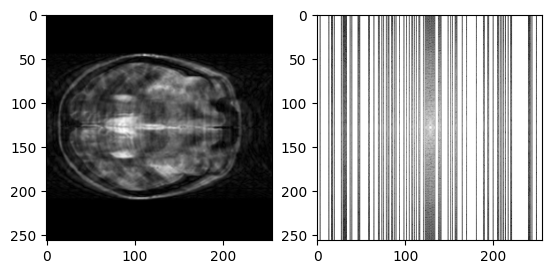

In [25]:
test_iu = i_u[0].detach().cpu().numpy()
test_dj = dj[0].detach().cpu().numpy()
plt.subplot(121), plt.imshow(test_iu[4], cmap='gray')
plt.subplot(122), plt.imshow(np.log(np.abs(test_dj[4])), cmap='gray')

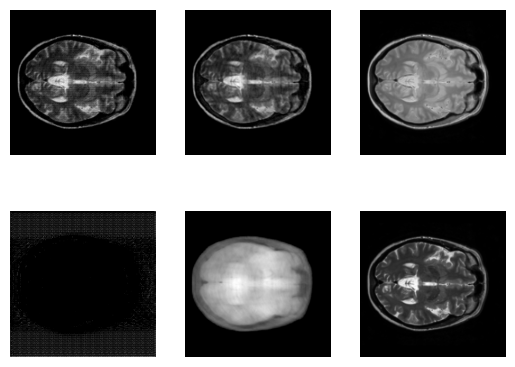

In [26]:
test_sample_gt_I0 = gt_I0[0].detach().cpu().numpy()
test_sample_gt_T2 = gt_T2[0].detach().cpu().numpy()
curr_test_pred_I0 = curr_I0_pred[0].detach().cpu().numpy()
curr_test_pred_T2 = curr_T2_pred[0].detach().cpu().numpy()
if test_compare:
    prev_test_pred_I0 = prev_I0_pred[0].detach().cpu().numpy()
    prev_test_pred_T2 = prev_T2_pred[0].detach().cpu().numpy()
    plt.subplot(231), plt.imshow(prev_test_pred_I0, cmap='gray'), plt.axis("off")
    plt.subplot(232), plt.imshow(curr_test_pred_I0, cmap='gray'), plt.axis("off")
    plt.subplot(233), plt.imshow(test_sample_gt_I0, cmap='gray'), plt.axis("off")
    plt.subplot(234), plt.imshow(prev_test_pred_T2, cmap='gray'), plt.axis("off")
    plt.subplot(235), plt.imshow(curr_test_pred_T2, cmap='gray'), plt.axis("off")
    plt.subplot(236), plt.imshow(test_sample_gt_T2, cmap='gray'), plt.axis("off")
else:
    plt.subplot(221), plt.imshow(curr_test_pred_I0, cmap='gray'), plt.axis("off")
    plt.subplot(222), plt.imshow(test_sample_gt_I0, cmap='gray'), plt.axis("off")
    plt.subplot(223), plt.imshow(curr_test_pred_T2, cmap='gray'), plt.axis("off")
    plt.subplot(224), plt.imshow(test_sample_gt_T2, cmap='gray'), plt.axis("off")

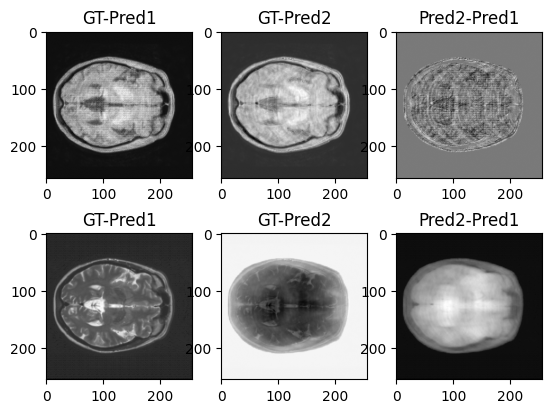

In [27]:
if test_compare:
    plt.subplot(231), plt.imshow(test_sample_gt_I0-prev_test_pred_I0, cmap='gray'), plt.title("GT-Pred1")
    plt.subplot(232), plt.imshow(test_sample_gt_I0-curr_test_pred_I0, cmap='gray'), plt.title("GT-Pred2")
    plt.subplot(233), plt.imshow(curr_test_pred_I0-prev_test_pred_I0, cmap='gray'), plt.title("Pred2-Pred1")
    plt.subplot(234), plt.imshow(test_sample_gt_T2-prev_test_pred_T2, cmap='gray'), plt.title("GT-Pred1")
    plt.subplot(235), plt.imshow(test_sample_gt_T2-curr_test_pred_T2, cmap='gray'), plt.title("GT-Pred2")
    plt.subplot(236), plt.imshow(curr_test_pred_T2-prev_test_pred_T2, cmap='gray'), plt.title("Pred2-Pred1")
else:
    plt.subplot(121), plt.imshow(test_sample_gt_I0-curr_test_pred_I0, cmap='gray'), plt.title("GT-Pred(I0)")
    plt.subplot(122), plt.imshow(test_sample_gt_T2-curr_test_pred_T2, cmap='gray'), plt.title("GT-Pred(T2)")